In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from rouge import Rouge
import joblib

In [5]:
# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yakuma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yakuma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yakuma\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
# Initialize Rouge for evaluation
rouge_scorer = Rouge()

In [7]:
class TextSummarizer:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        self.vectorizer = TfidfVectorizer(stop_words='english')

    def preprocess_text(self, text):
        # Convert to lowercase
        text = text.lower()
        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Tokenize
        words = word_tokenize(text)
        # Remove stopwords and lemmatize
        words = [self.lemmatizer.lemmatize(word) for word in words if word not in self.stop_words]
        return ' '.join(words)

    def get_sentence_scores(self, text):
        sentences = sent_tokenize(text)
        # Preprocess sentences
        processed_sentences = [self.preprocess_text(sentence) for sentence in sentences]

        # Calculate TF-IDF scores
        tfidf_matrix = self.vectorizer.fit_transform(processed_sentences)

        # Calculate sentence scores based on TF-IDF weights
        sentence_scores = []
        for i in range(len(sentences)):
            score = np.mean(tfidf_matrix[i].toarray())
            sentence_scores.append((sentences[i], score))

        return sentence_scores

    def summarize(self, text, num_sentences=3):
        if not text:
            return ""

        # Get sentence scores
        sentence_scores = self.get_sentence_scores(text)

        # Sort sentences by score
        sentence_scores.sort(key=lambda x: x[1], reverse=True)

        # Select top n sentences
        selected_sentences = [sentence[0] for sentence in sentence_scores[:num_sentences]]

        # Sort sentences by their original position
        original_sentences = sent_tokenize(text)
        final_sentences = [sent for sent in original_sentences if sent in selected_sentences]

        return ' '.join(final_sentences)

In [9]:
from text_summarizer import TextSummarizer

# Train and save the summarizer
summarizer = TextSummarizer()


In [10]:
import pandas as pd

# Load the dataset and train if needed
train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('validation.csv')
test_df = pd.read_csv('test.csv')

In [17]:
# Train the summarizer
print("Training the summarizer...")
train_sample = train_df['article'].tolist()  
for text in train_sample:
    summarizer.summarize(text)

Training the summarizer...


In [11]:
# Evaluate on a sample of validation data
print("Evaluating the summarizer...")
val_sample = val_df
val_summaries = [summarizer.summarize(text, num_sentences=3) for text in val_sample['article'].values]
val_highlights = val_sample['highlights'].tolist()
val_scores = rouge_scorer.get_scores(val_summaries, val_highlights, avg=True)

# Print scores in a formatted way
print("\nValidation ROUGE Scores:")
print("=" * 40)

for rouge_type, scores in val_scores.items():
    print(f"\n{rouge_type.upper()}:")
    print("-" * 20)
    print(f"Precision: {scores['p']:.4f}")
    print(f"Recall:    {scores['r']:.4f}")
    print(f"F1-Score:  {scores['f']:.4f}")

Evaluating the summarizer...

Validation ROUGE Scores:

ROUGE-1:
--------------------
Precision: 0.2207
Recall:    0.4000
F1-Score:  0.2762

ROUGE-2:
--------------------
Precision: 0.0721
Recall:    0.1376
F1-Score:  0.0911

ROUGE-L:
--------------------
Precision: 0.1997
Recall:    0.3616
F1-Score:  0.2498


In [10]:
# Save the trained model
joblib.dump(summarizer, 'text_summarizer_model.joblib')

['text_summarizer_model.joblib']

In [12]:
# Test loading and using the model
print("\nTesting the saved model...")
loaded_summarizer = joblib.load('text_summarizer_model.joblib')
test_text = "I am writing to express my deep frustration and concern regarding the deplorable condition of the main road in our neighborhood. Over the past few months, the road has deteriorated significantly, and it is now riddled with numerous potholes of varying sizes. These potholes pose a serious hazard to both drivers and pedestrians. Every day, I witness vehicles swerving dangerously to avoid these craters, which increases the risk of accidents. The situation is particularly dire during the rainy season when the potholes fill with water, making them even more difficult to see and navigate. This not only damages vehicles but also endangers the lives of those who use the road. Despite multiple complaints to the local authorities, no action has been taken to repair the road. The lack of maintenance and timely repairs is unacceptable and reflects poorly on the administration's commitment to public safety. I urge the concerned authorities to prioritize the repair of this road to prevent any further accidents and ensure the safety of all residents."
summary = loaded_summarizer.summarize(test_text, num_sentences=2)
print("Test Summary:", summary)


Testing the saved model...
Test Summary: I am writing to express my deep frustration and concern regarding the deplorable condition of the main road in our neighborhood. The lack of maintenance and timely repairs is unacceptable and reflects poorly on the administration's commitment to public safety.



Detailed ROUGE Scores Statistics:

ROUGE-1:
R: 0.4000
P: 0.2207
F: 0.2762

ROUGE-2:
R: 0.1376
P: 0.0721
F: 0.0911

ROUGE-L:
R: 0.3616
P: 0.1997
F: 0.2498


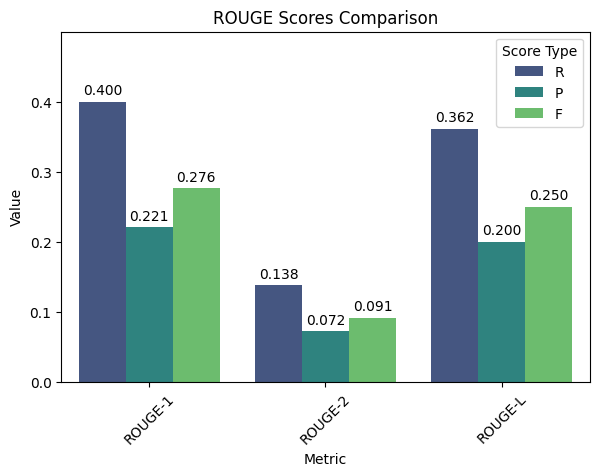

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def visualize_rouge_scores(val_scores):
    # Convert ROUGE scores to a more plottable format
    data = {
        'Metric': [],
        'Score Type': [],
        'Value': []
    }
    
    for rouge_type, scores in val_scores.items():
        for score_type, value in scores.items():
            data['Metric'].append(rouge_type.upper())
            data['Score Type'].append(score_type.upper())
            data['Value'].append(value)
    
    df = pd.DataFrame(data)
    
    # Create subplots
    fig = plt.figure(figsize=(15, 10))
    
    # 1. Bar plot comparing all metrics
    plt.subplot(2, 2, 1)
    sns.barplot(data=df, x='Metric', y='Value', hue='Score Type', palette='viridis')
    plt.title('ROUGE Scores Comparison')
    plt.xticks(rotation=45)
    plt.ylim(0, max(df['Value']) + 0.1)
    
    # Add value labels on bars
    for container in plt.gca().containers:
        plt.bar_label(container, fmt='%.3f', padding=3)
    
    # # 2. Horizontal bar chart for F1 scores
    # plt.subplot(2, 2, 2)
    # f1_scores = df[df['Score Type'] == 'F']
    # sns.barplot(data=f1_scores, y='Metric', x='Value', hue='Metric', palette='rocket', orient='h')
    # plt.title('F1 Scores by ROUGE Metric')
    # plt.xlabel('F1 Score')
    
    # # Add value labels
    # for i, v in enumerate(f1_scores['Value']):
    #     plt.text(v, i, f'{v:.3f}', va='center', padding=5)
    
    # # 3. Spider/Radar chart for all metrics
    # ax = plt.subplot(2, 2, (3, 4), projection='polar')
    
    # # Prepare data for radar chart
    # categories = df['Metric'].unique()
    # score_types = df['Score Type'].unique()
    # angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False)
    
    # # Close the plot by appending first value
    # angles = np.concatenate((angles, [angles[0]]))
    
    # # Plot each score type
    # for score_type in score_types:
    #     values = df[df['Score Type'] == score_type]['Value'].values
    #     values = np.concatenate((values, [values[0]]))
    #     ax.plot(angles, values, 'o-', linewidth=2, label=score_type)
    #     ax.fill(angles, values, alpha=0.25)
    
    # # Set the labels
    # ax.set_xticks(angles[:-1])
    # ax.set_xticklabels(categories)
    # ax.set_ylim(0, max(df['Value']) + 0.1)
    # plt.title('ROUGE Scores Radar Chart')
    # plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    
    # plt.tight_layout()
    # plt.show()

    # Print detailed statistics
    print("\nDetailed ROUGE Scores Statistics:")
    print("=" * 50)
    for rouge_type in df['Metric'].unique():
        print(f"\n{rouge_type}:")
        for score_type in df['Score Type'].unique():
            value = df[(df['Metric'] == rouge_type) & 
                      (df['Score Type'] == score_type)]['Value'].values[0]
            print(f"{score_type}: {value:.4f}")

# Use the function with your validation scores
# Assuming val_scores is your dictionary of ROUGE scores
visualize_rouge_scores(val_scores)